### Библиотеки
___

In [1]:
from datetime import timedelta
import numpy as np
import holidays
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.metrics import mean_squared_error, r2_score
import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

### Датасет
___

In [ ]:
data = pd.read_csv("sales_assortments.csv", index_col="Index")

In [3]:
data.sample(5)

,Date,Sales,Assortment
Index,,,
1516,2020 jul 22,401331.978286,drink
1658,2020 oct 18,5875.125732,drink
297,2017 apr 25,27753.272561,candy
411,2017 jan 21,17439.589589,savory_snacks
1460,2020 feb 25,4562.025035,savory_snacks


In [4]:
data.Date = pd.to_datetime(data.Date, format="%Y %b %d")
data.sample(5)

,Date,Sales,Assortment
Index,,,
603,2017-09-01,8509.622801,drink
1698,2020-09-29,25187.078681,drink
18,2014-08-19,272607.170179,drink
692,2018-08-30,150079.717278,drink
445,2017-07-24,4156.838385,candy


### Добавляем фичей
___

In [5]:
min_year = data["Date"].min().year
max_year = data["Date"].max().year

year_range = range(min_year, max_year + 1)
us_holidays = holidays.US(years=year_range)


def check_next_week_holiday(date):
    for i in range(1, 8):
        if (date + timedelta(days=i)) in us_holidays:
            return 1
    return 0

In [6]:
data["DayOfWeek"] = data["Date"].dt.dayofweek
data["IsWeekend"] = data["DayOfWeek"].isin([5, 6]).astype(int)
data["Month"] = data["Date"].dt.month
data["IsRealHoliday"] = data["Date"].apply(lambda date: int(date in us_holidays))
data["IsHolidayNextWeek"] = data["Date"].apply(check_next_week_holiday)

In [7]:
data.columns, data.Assortment.unique()

(Index(['Date', 'Sales', 'Assortment', 'DayOfWeek', 'IsWeekend', 'Month',
        'IsRealHoliday', 'IsHolidayNextWeek'],
       dtype='object'),
 array(['drink', 'savory_snacks', 'candy'], dtype=object))

In [8]:
data.sample(5)

,Date,Sales,Assortment,DayOfWeek,IsWeekend,Month,IsRealHoliday,IsHolidayNextWeek
Index,,,,,,,,
245,2016-10-31,110156.750152,drink,0,0,10,0,0
278,2017-04-03,27305.110172,savory_snacks,0,0,4,0,0
1104,2019-01-19,5846.336074,savory_snacks,5,1,1,0,1
693,2018-08-31,37519.786321,drink,4,0,8,0,1
345,2017-12-13,22892.683153,savory_snacks,2,0,12,0,0


### Графички
____

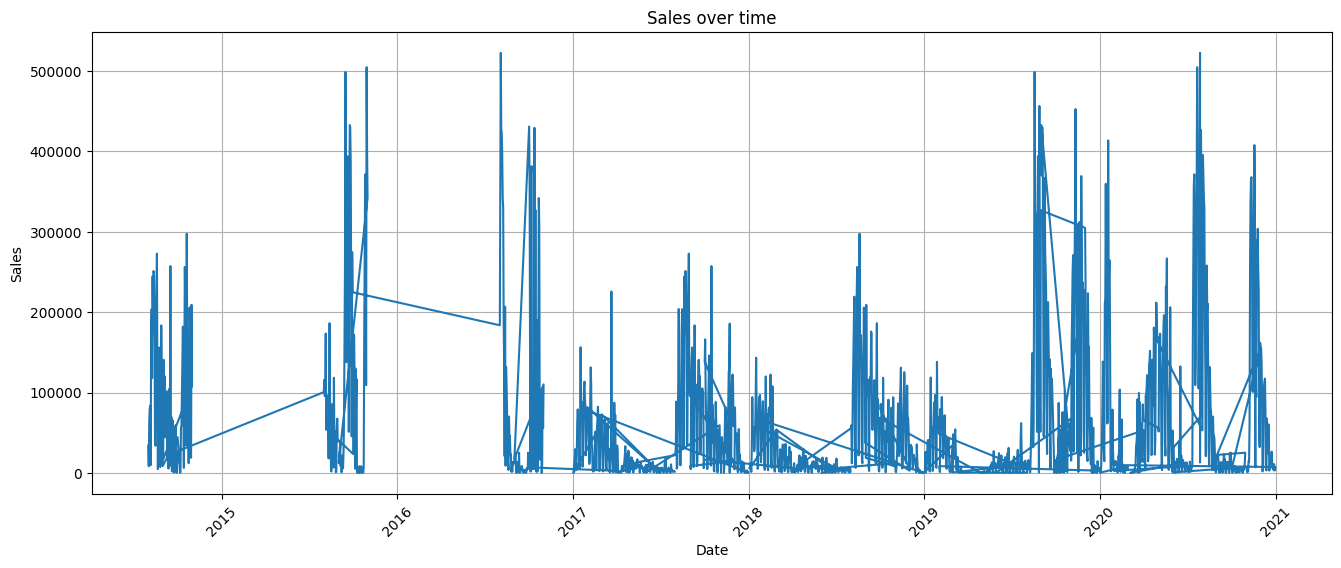

In [9]:
plt.figure(figsize=(16, 6))
plt.plot(data["Date"], data["Sales"], label="Sales")
plt.title("Sales over time")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

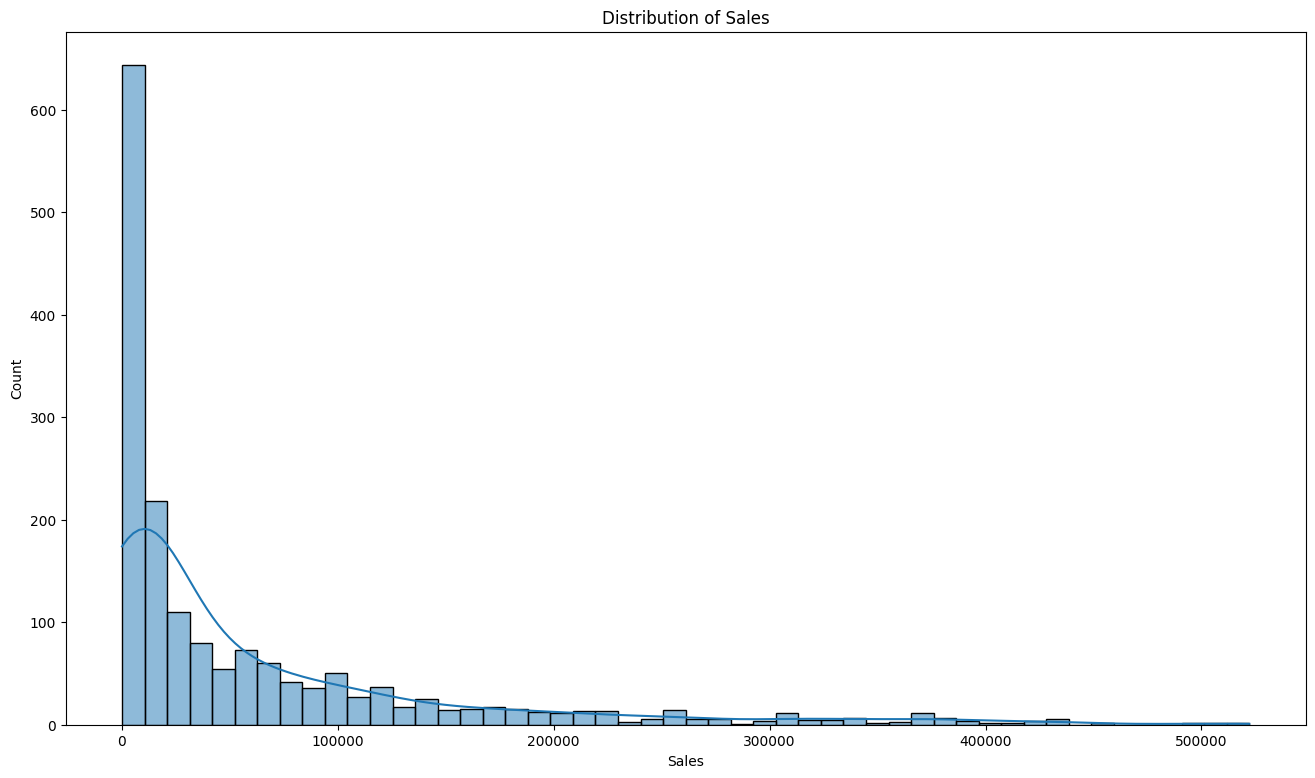

In [10]:
plt.figure(figsize=(16, 9))
sns.histplot(data["Sales"], bins=50, kde=True)
plt.title("Distribution of Sales")
plt.xlabel("Sales")
plt.ylabel("Count")
plt.show()

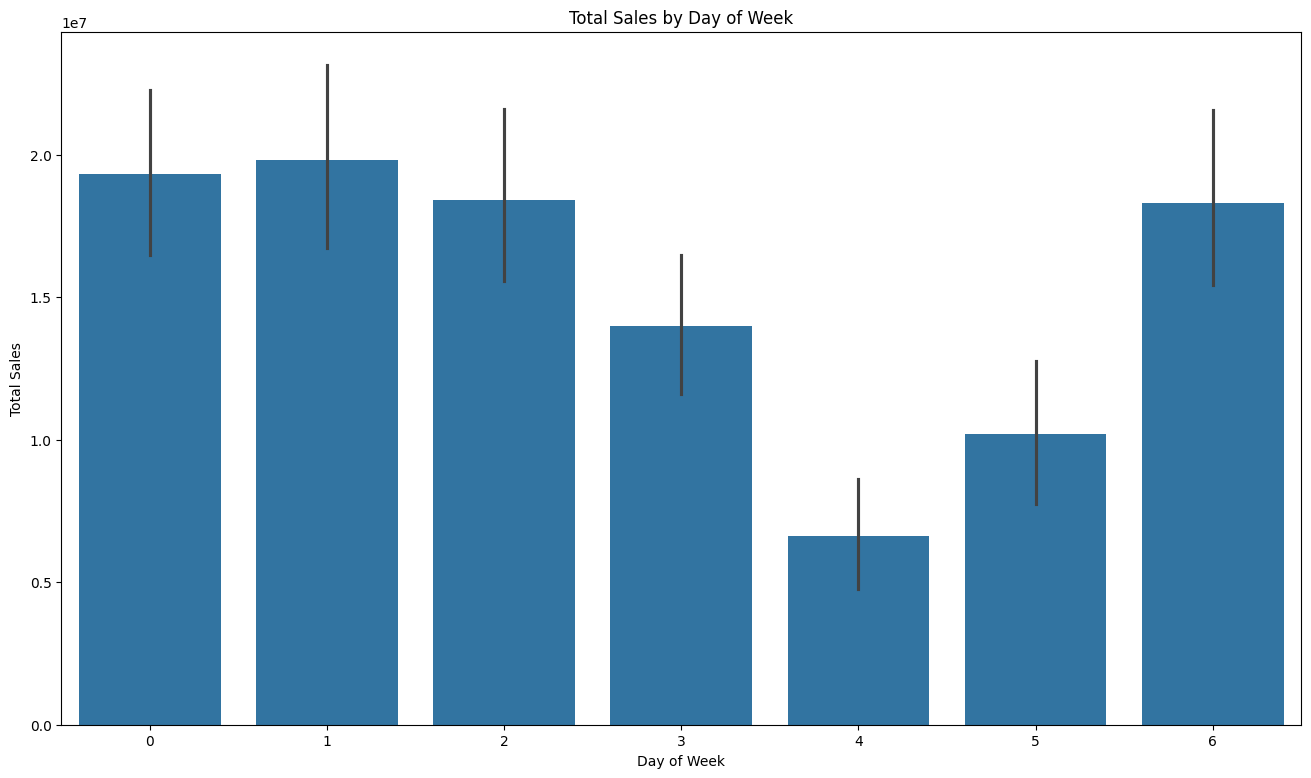

In [11]:
plt.figure(figsize=(16, 9))
sns.barplot(x="DayOfWeek", y="Sales", data=data, estimator=sum)
plt.title("Total Sales by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Total Sales")
plt.show()

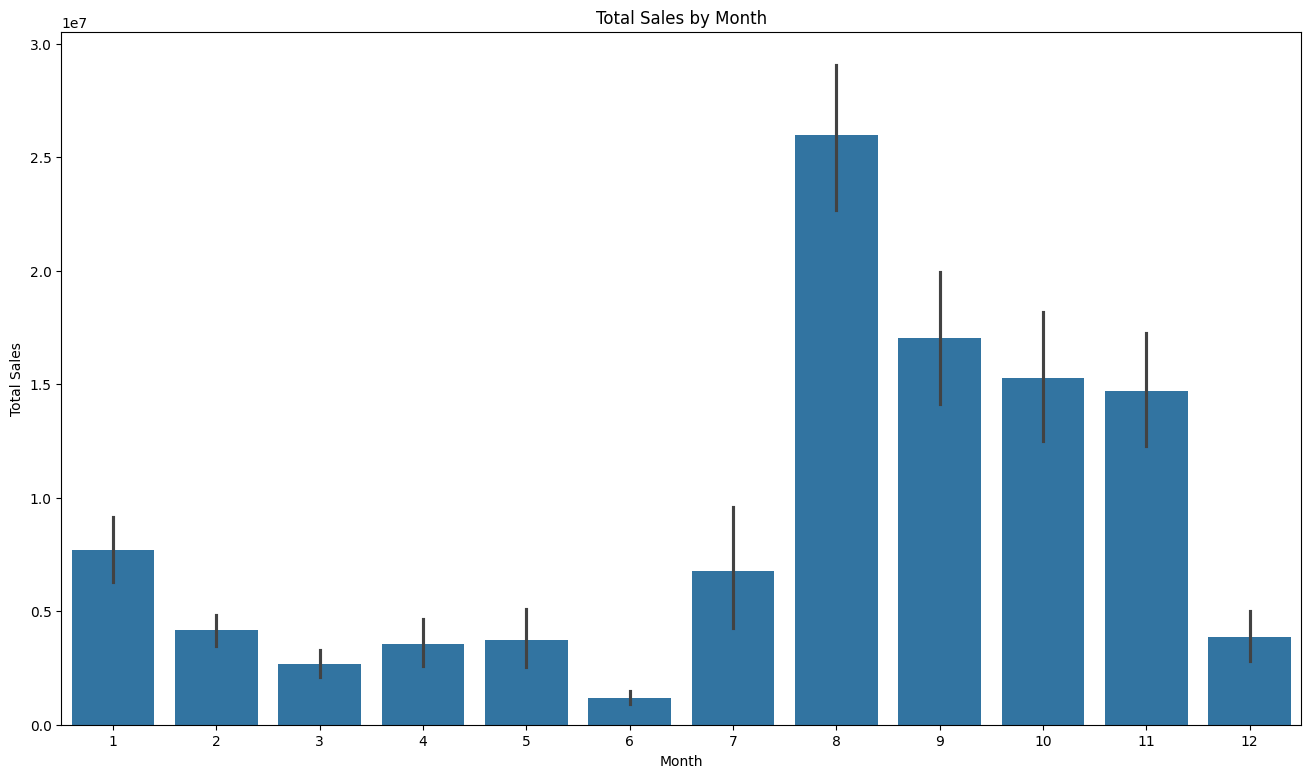

In [12]:
plt.figure(figsize=(16, 9))
sns.barplot(x="Month", y="Sales", data=data, estimator=sum)
plt.title("Total Sales by Month")
plt.xlabel("Month")
plt.ylabel("Total Sales")
plt.show()

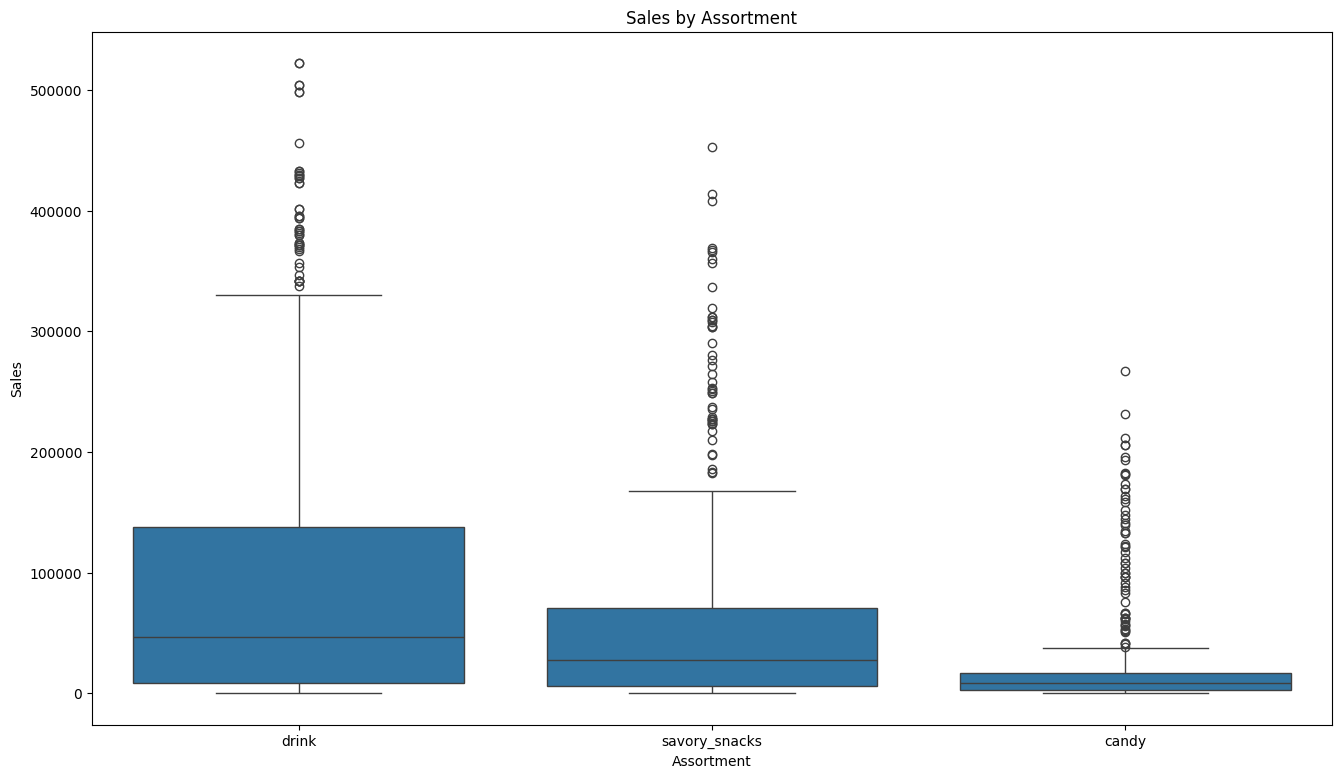

In [13]:
plt.figure(figsize=(16, 9))
sns.boxplot(x="Assortment", y="Sales", data=data)
plt.title("Sales by Assortment")
plt.xlabel("Assortment")
plt.ylabel("Sales")
plt.show()

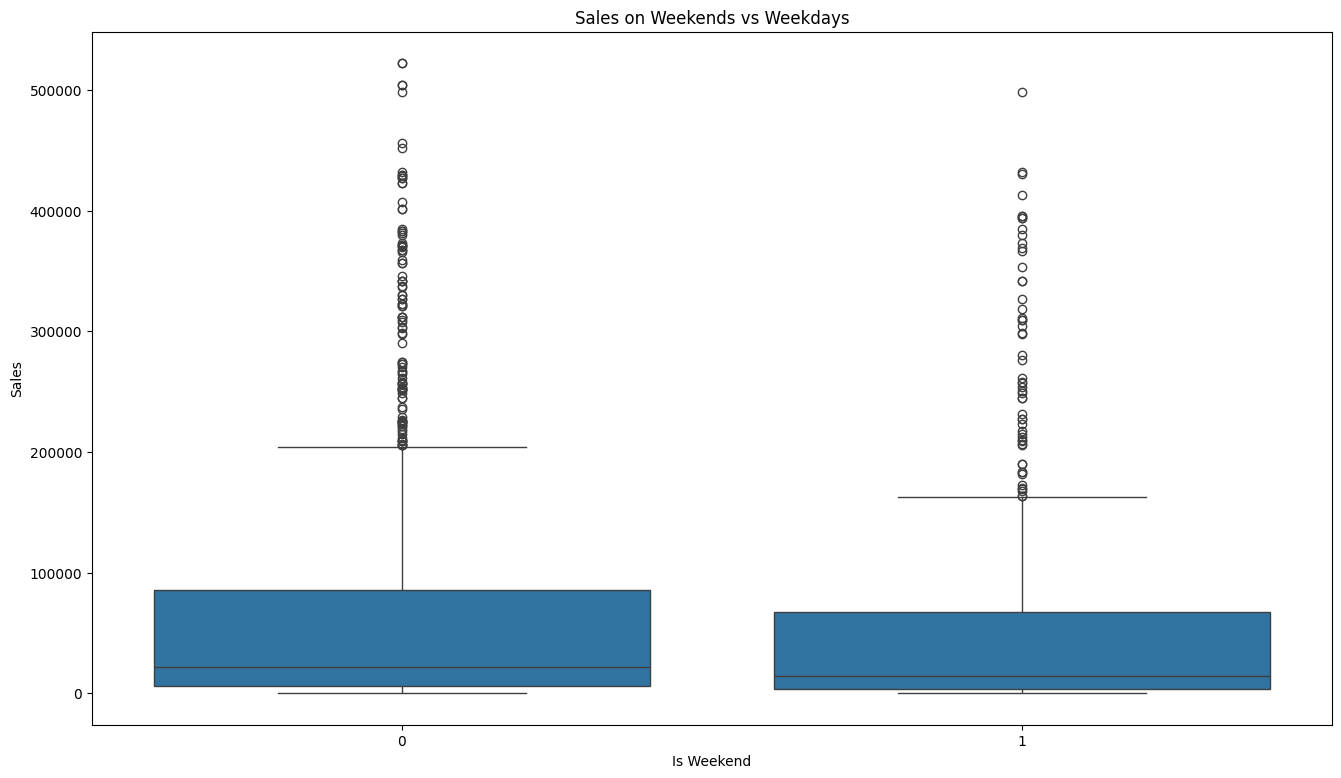

In [14]:
plt.figure(figsize=(16, 9))
sns.boxplot(x="IsWeekend", y="Sales", data=data)
plt.title("Sales on Weekends vs Weekdays")
plt.xlabel("Is Weekend")
plt.ylabel("Sales")
plt.show()

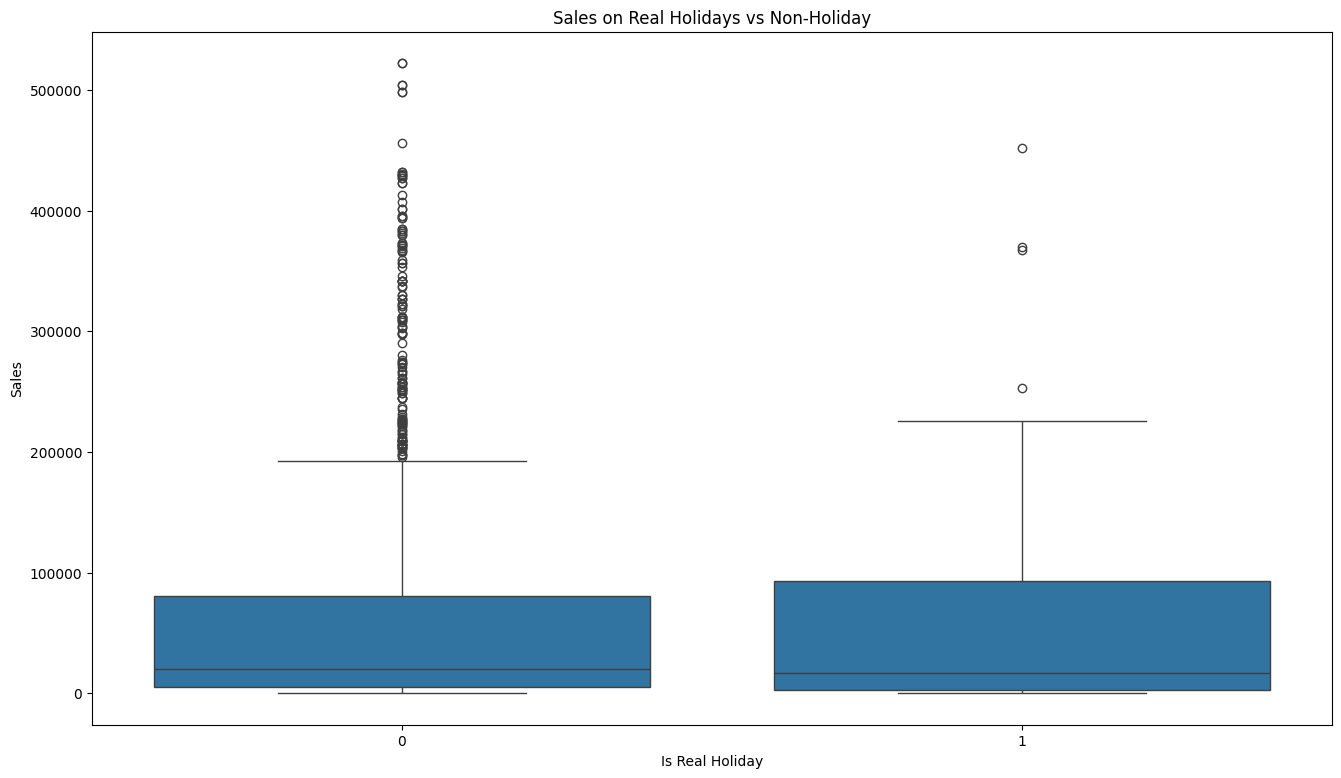

In [15]:
plt.figure(figsize=(16, 9))
sns.boxplot(x="IsRealHoliday", y="Sales", data=data)
plt.title("Sales on Real Holidays vs Non-Holiday")
plt.xlabel("Is Real Holiday")
plt.ylabel("Sales")
plt.show()

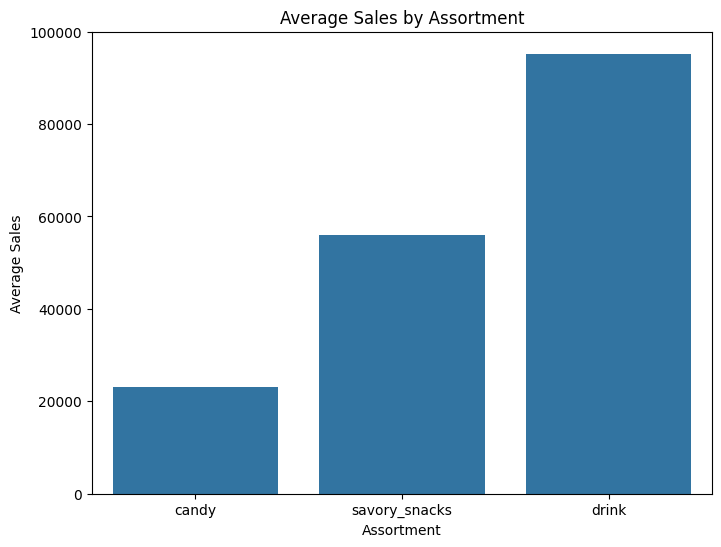

In [17]:
assortment_mean = data.groupby("Assortment")["Sales"].mean().sort_values()

plt.figure(figsize=(8, 6))
sns.barplot(x=assortment_mean.index, y=assortment_mean.values)
plt.title("Average Sales by Assortment")
plt.ylabel("Average Sales")
plt.xlabel("Assortment")
plt.show()

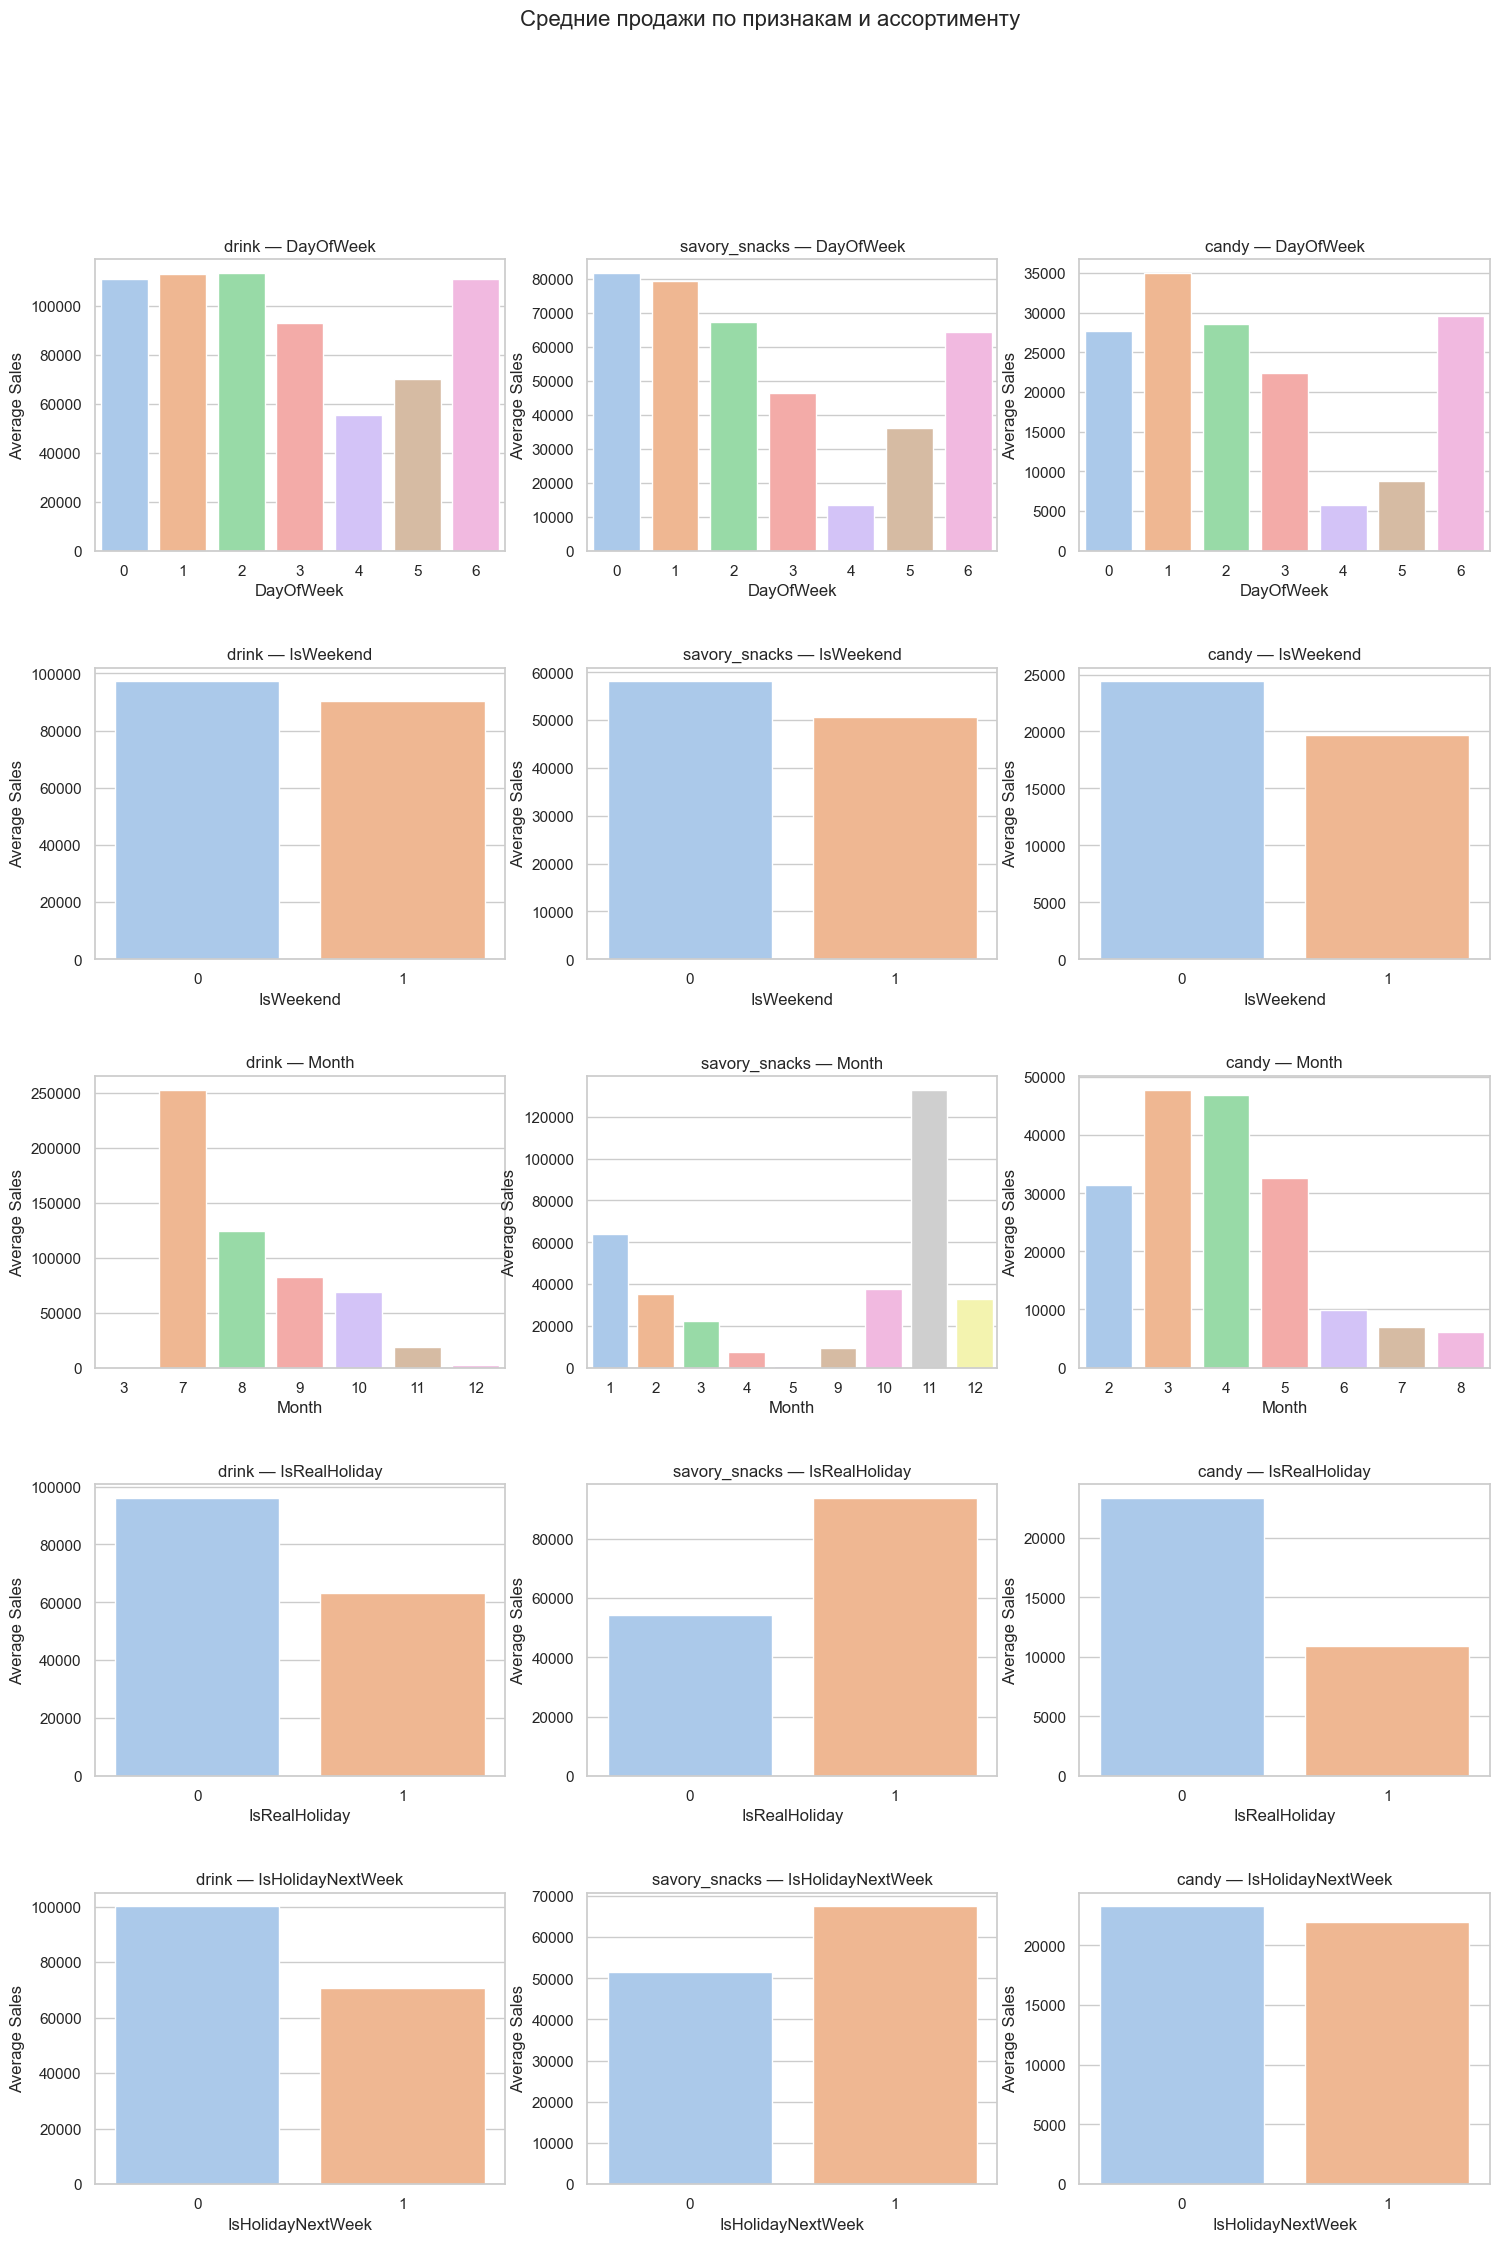

In [ ]:
features = ["DayOfWeek", "IsWeekend", "Month", "IsRealHoliday", "IsHolidayNextWeek"]

sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=len(features), ncols=3, figsize=(18, 25))
plt.subplots_adjust(hspace=0.4)

for i, feature in enumerate(features):
    for j, assortment in enumerate(data["Assortment"].unique()):
        ax = axes[i, j]
        subset = data[data["Assortment"] == assortment]

        sns.barplot(
            data=subset,
            x=feature,
            y="Sales",
            hue=feature,
            dodge=False,
            legend=False,
            errorbar=None,
            palette="pastel",
            ax=ax,
        )
        ax.set_title(f"{assortment} — {feature}", fontsize=12)
        ax.set_xlabel(feature)
        ax.set_ylabel("Average Sales")

plt.suptitle("Средние продажи по признакам и ассортименту", fontsize=16)
plt.show()

### Данные плохо синтезированны, так что хорошего результата ждать не стоит

### Добавляем 100 nan и потом убираем их
___

In [30]:
data_with_nan = data.copy()
nan_indices = np.random.choice(data_with_nan.index, size=100, replace=False)
data_with_nan.loc[nan_indices, "Sales"] = np.nan
data_with_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1700 entries, 0 to 1699
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1700 non-null   datetime64[ns]
 1   Sales              1600 non-null   float64       
 2   Assortment         1700 non-null   object        
 3   DayOfWeek          1700 non-null   int32         
 4   IsWeekend          1700 non-null   int64         
 5   Month              1700 non-null   int32         
 6   IsRealHoliday      1700 non-null   int64         
 7   IsHolidayNextWeek  1700 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(3), object(1)
memory usage: 170.8+ KB


In [ ]:
group_cols = [
    "Assortment",
    "Month",
    "IsWeekend",
    "IsRealHoliday",
    "IsHolidayNextWeek",
    "DayOfWeek",
]

group_means = data_with_nan.groupby(group_cols)["Sales"].mean()
group_means

Assortment     Month  IsWeekend  IsRealHoliday  IsHolidayNextWeek  DayOfWeek
candy          2      0          0              0                  1              931.222405
                                                1                  1                     NaN
                                                                   2            66286.227746
                                                                   3            10785.362513
                                                                   4             9987.071033
                                                                                    ...     
savory_snacks  12     0          1              1                  4             5876.325019
                      1          0              0                  5            32180.594491
                                                                   6            70060.958767
                                                1                  5             5843.

In [ ]:
def fill_sales(row):
    if pd.isna(row["Sales"]):
        key = tuple(row[col] for col in group_cols)
        if key in group_means:
            return group_means[key]
    return row["Sales"]


data_with_nan["Sales"] = data_with_nan.apply(fill_sales, axis=1)

In [33]:
data_with_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1700 entries, 0 to 1699
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1700 non-null   datetime64[ns]
 1   Sales              1697 non-null   float64       
 2   Assortment         1700 non-null   object        
 3   DayOfWeek          1700 non-null   int32         
 4   IsWeekend          1700 non-null   int64         
 5   Month              1700 non-null   int32         
 6   IsRealHoliday      1700 non-null   int64         
 7   IsHolidayNextWeek  1700 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(3), object(1)
memory usage: 170.8+ KB


In [34]:
data_with_nan = data_with_nan.dropna(subset=["Sales"])
data_with_nan.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1697 entries, 0 to 1699
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               1697 non-null   datetime64[ns]
 1   Sales              1697 non-null   float64       
 2   Assortment         1697 non-null   object        
 3   DayOfWeek          1697 non-null   int32         
 4   IsWeekend          1697 non-null   int64         
 5   Month              1697 non-null   int32         
 6   IsRealHoliday      1697 non-null   int64         
 7   IsHolidayNextWeek  1697 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int32(2), int64(3), object(1)
memory usage: 106.1+ KB


In [35]:
data = data_with_nan

### Сплитим, энкодим и обучаем
___

In [20]:
features = [
    "Assortment",
    "DayOfWeek",
    "IsWeekend",
    "Month",
    "IsRealHoliday",
    "IsHolidayNextWeek",
]
target = "Sales"

X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train_cb, X_test_cb, y_train_cb, y_test_cb = (
    X_train.copy(),
    X_test.copy(),
    y_train.copy(),
    y_test.copy(),
)

In [21]:
te = TargetEncoder()
X_train[["Assortment"]] = te.fit_transform(X_train[["Assortment"]], y_train)
X_test[["Assortment"]] = te.transform(X_test[["Assortment"]])

In [22]:
numeric_cols = ["DayOfWeek", "IsWeekend", "Month", "IsRealHoliday", "IsHolidayNextWeek"]
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

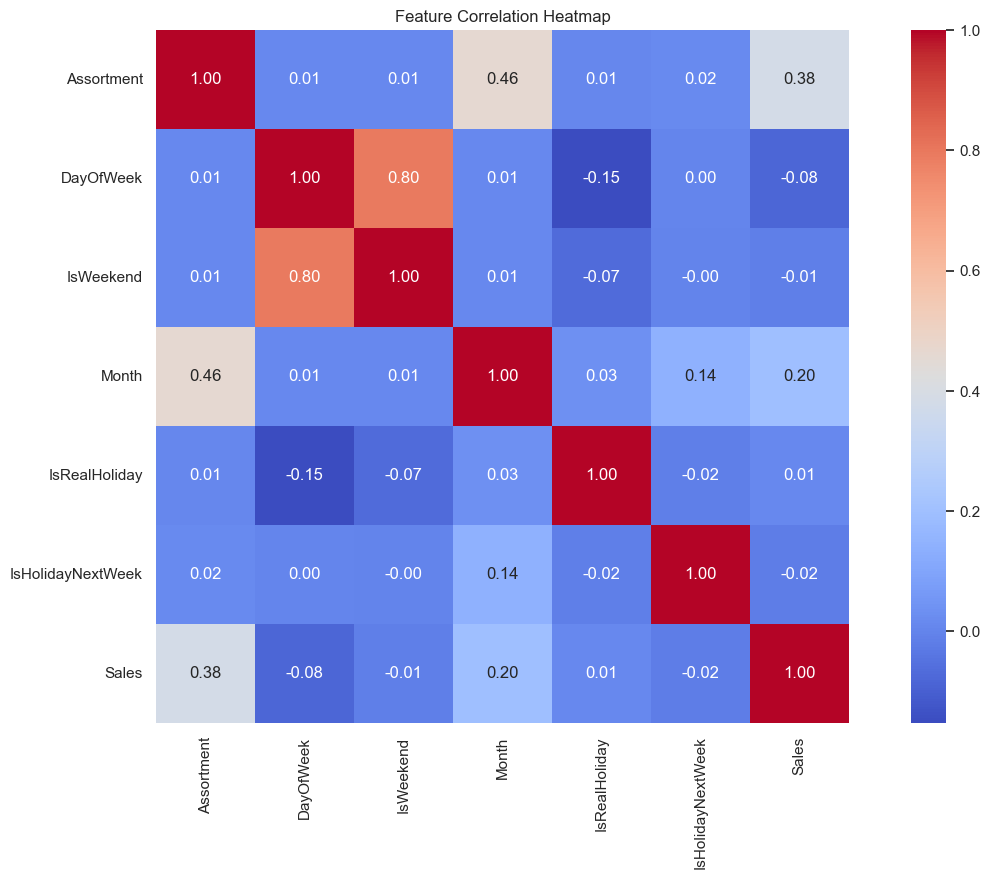

In [49]:
corr_matrix = pd.concat([X_train, y_train], axis=1).corr()

plt.figure(figsize=(16, 9))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
model_cb = CatBoostRegressor(
    iterations=1000,
    depth=6,
    loss_function="RMSE",
    eval_metric="RMSE",
    random_seed=42,
    verbose=100,
)

model_cb.fit(
    X_train_cb,
    y_train_cb,
    eval_set=(X_test_cb, y_test_cb),
    cat_features=["Assortment"],
    early_stopping_rounds=50,
)

Learning rate set to 0.053439
0:	learn: 86561.8284441	test: 111733.2194540	best: 111733.2194540 (0)	total: 65.1ms	remaining: 1m 5s
100:	learn: 73756.4935913	test: 107907.2103812	best: 107907.2103812 (100)	total: 110ms	remaining: 977ms
200:	learn: 71400.2999128	test: 105627.6935213	best: 105627.6935213 (200)	total: 142ms	remaining: 563ms
300:	learn: 69790.5163324	test: 105362.7016653	best: 105362.7016653 (300)	total: 175ms	remaining: 406ms
Stopped by overfitting detector  (50 iterations wait)

bestTest = 105362.7017
bestIteration = 300

Shrink model to first 301 iterations.


In [38]:
y_pred_cb = model_cb.predict(X_test_cb)

# --- Метрики ---
rmse_cb = np.sqrt(mean_squared_error(y_test_cb, y_pred_cb))
r2_cb = r2_score(y_test_cb, y_pred_cb)

print(f"CatBoost RMSE: {rmse_cb:.4f}")
print(f"CatBoost R²: {r2_cb:.4f}")

CatBoost RMSE: 105362.7016
CatBoost R²: 0.0876


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
def train_model(
    model,
    train_loader,
    val_loader,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=25,
):
    best_model_wts = model.state_dict()
    best_rmse = float("inf")

    losses = {"train": [], "val": []}
    metrics = {"train": {"RMSE": [], "R2": []}, "val": {"RMSE": [], "R2": []}}

    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = val_loader

            running_loss = 0.0
            all_labels = []
            all_preds = []

            for inputs, labels in tqdm.tqdm(loader, leave=False, desc=f"{phase} iter:"):
                inputs, labels = inputs.to(device), labels.to(device)

                if phase == "train":
                    optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                all_labels.append(labels.detach().cpu().numpy())
                all_preds.append(outputs.detach().cpu().numpy())

            epoch_loss = running_loss / dataset_sizes[phase]
            y_true = np.vstack(all_labels)
            y_pred = np.vstack(all_preds)
            epoch_rmse = np.sqrt(mean_squared_error(y_true, y_pred))
            epoch_r2 = r2_score(y_true, y_pred)

            losses[phase].append(epoch_loss)
            metrics[phase]["RMSE"].append(epoch_rmse)
            metrics[phase]["R2"].append(epoch_r2)

            tqdm.tqdm.write(
                f"{phase} Epoch {epoch + 1}/{num_epochs} "
                f"Loss: {epoch_loss:.4f} RMSE: {epoch_rmse:.4f} R2: {epoch_r2:.4f}"
            )

            # сохраняем лучшую модель по RMSE на валидации
            if phase == "val" and epoch_rmse < best_rmse:
                best_rmse = epoch_rmse
                best_model_wts = model.state_dict()

        # шаг scheduler по RMSE на валидации
        scheduler.step(epoch_rmse)

    print(f"Best val RMSE: {best_rmse:.4f}")
    model.load_state_dict(best_model_wts)
    return model, (losses, metrics)


In [41]:
def plot_grafs(metrics):
    losses, metric_vals = metrics

    plt.figure(figsize=(16, 6))
    plt.plot(losses["train"], label="Train Loss")
    plt.plot(losses["val"], label="Validation Loss")
    plt.title("Training and Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    plt.figure(figsize=(16, 6))
    plt.plot(metric_vals["train"]["RMSE"], label="Train RMSE")
    plt.plot(metric_vals["val"]["RMSE"], label="Validation RMSE")
    plt.title("Training and Validation RMSE")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE")
    plt.legend()
    plt.show()

    plt.figure(figsize=(16, 6))
    plt.plot(metric_vals["train"]["R2"], label="Train R2")
    plt.plot(metric_vals["val"]["R2"], label="Validation R2")
    plt.title("Training and Validation R2 Score")
    plt.xlabel("Epochs")
    plt.ylabel("R2")
    plt.legend()
    plt.show()


In [42]:
class Model(nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)  # выходной слой для регрессии
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x

In [43]:
batch_size = 64

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

dataset_sizes = {"train": len(train_dataset), "val": len(val_dataset)}

In [44]:
model = Model(input_dim=X_train_tensor.shape[1]).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", factor=0.5, patience=5
)

In [45]:
model_trained, metrics = train_model(
    model,
    train_loader,
    val_loader,
    dataset_sizes,
    criterion,
    optimizer,
    scheduler,
    num_epochs=50,
)

train Epoch 1/50 Loss: 8718119026.4471 RMSE: 93370.8676 R2: -0.1396


val Epoch 1/50 Loss: 13118976391.5294 RMSE: 114538.0985 R2: -0.0782


train Epoch 2/50 Loss: 6788603000.4706 RMSE: 82392.9783 R2: 0.1126


val Epoch 2/50 Loss: 12954457081.9765 RMSE: 113817.6439 R2: -0.0647


train Epoch 3/50 Loss: 6812981151.6235 RMSE: 82540.7854 R2: 0.1094


val Epoch 3/50 Loss: 12975176420.8941 RMSE: 113908.6331 R2: -0.0664


train Epoch 4/50 Loss: 6763957838.3059 RMSE: 82243.2871 R2: 0.1158


val Epoch 4/50 Loss: 12986124510.8706 RMSE: 113956.6727 R2: -0.0673


train Epoch 5/50 Loss: 6752764434.0706 RMSE: 82175.2087 R2: 0.1173


val Epoch 5/50 Loss: 13043031582.1176 RMSE: 114206.0992 R2: -0.0720


train Epoch 6/50 Loss: 6729870784.7529 RMSE: 82035.7963 R2: 0.1203


val Epoch 6/50 Loss: 12996812257.8824 RMSE: 114003.5649 R2: -0.0682


train Epoch 7/50 Loss: 6673086259.2000 RMSE: 81688.9648 R2: 0.1277


val Epoch 7/50 Loss: 13029542460.2353 RMSE: 114147.0187 R2: -0.0709


train Epoch 8/50 Loss: 6743425168.5647 RMSE: 82118.3630 R2: 0.1185


val Epoch 8/50 Loss: 13010259666.8235 RMSE: 114062.5221 R2: -0.0693


train Epoch 9/50 Loss: 6741408653.5529 RMSE: 82106.0793 R2: 0.1188


val Epoch 9/50 Loss: 12984866063.0588 RMSE: 113951.1508 R2: -0.0672


train Epoch 10/50 Loss: 6943864687.4353 RMSE: 83329.8525 R2: 0.0923


val Epoch 10/50 Loss: 13013412972.4235 RMSE: 114076.3511 R2: -0.0695


train Epoch 11/50 Loss: 6641988577.8824 RMSE: 81498.3964 R2: 0.1318


val Epoch 11/50 Loss: 12996010236.9882 RMSE: 114000.0483 R2: -0.0681


train Epoch 12/50 Loss: 6718559722.9176 RMSE: 81966.8210 R2: 0.1218


val Epoch 12/50 Loss: 12979998659.7647 RMSE: 113929.7973 R2: -0.0668


train Epoch 13/50 Loss: 6793338717.3647 RMSE: 82421.7105 R2: 0.1120


val Epoch 13/50 Loss: 13005401009.6941 RMSE: 114041.2209 R2: -0.0689


train Epoch 14/50 Loss: 6727792627.9529 RMSE: 82023.1257 R2: 0.1206


val Epoch 14/50 Loss: 13053335094.2118 RMSE: 114251.1950 R2: -0.0728


train Epoch 15/50 Loss: 6571479329.1294 RMSE: 81064.6596 R2: 0.1410


val Epoch 15/50 Loss: 13008790558.1176 RMSE: 114056.0895 R2: -0.0692


train Epoch 16/50 Loss: 6841931414.5882 RMSE: 82715.9736 R2: 0.1057


val Epoch 16/50 Loss: 13002135443.5765 RMSE: 114026.9071 R2: -0.0686


train Epoch 17/50 Loss: 6640196957.3647 RMSE: 81487.4047 R2: 0.1320


val Epoch 17/50 Loss: 13015498758.0235 RMSE: 114085.4888 R2: -0.0697


train Epoch 18/50 Loss: 6781705318.4000 RMSE: 82351.1094 R2: 0.1135


val Epoch 18/50 Loss: 12954243897.2235 RMSE: 113816.7127 R2: -0.0647


train Epoch 19/50 Loss: 6686835483.1059 RMSE: 81773.0745 R2: 0.1259


val Epoch 19/50 Loss: 13031445660.6118 RMSE: 114155.3614 R2: -0.0710


train Epoch 20/50 Loss: 6694926598.0235 RMSE: 81822.5295 R2: 0.1249


val Epoch 20/50 Loss: 12982304804.1412 RMSE: 113939.9219 R2: -0.0670


train Epoch 21/50 Loss: 6740643457.5059 RMSE: 82101.4241 R2: 0.1189


val Epoch 21/50 Loss: 13007217477.2706 RMSE: 114049.1852 R2: -0.0690


train Epoch 22/50 Loss: 6750941268.3294 RMSE: 82164.1175 R2: 0.1175


val Epoch 22/50 Loss: 13023452184.0941 RMSE: 114120.3452 R2: -0.0704


train Epoch 23/50 Loss: 6661819922.0706 RMSE: 81619.9693 R2: 0.1292


val Epoch 23/50 Loss: 13017115111.9059 RMSE: 114092.5704 R2: -0.0699


train Epoch 24/50 Loss: 6677818054.7765 RMSE: 81717.9164 R2: 0.1271


val Epoch 24/50 Loss: 13003677226.1647 RMSE: 114033.6691 R2: -0.0687


train Epoch 25/50 Loss: 6779866316.8000 RMSE: 82339.9393 R2: 0.1138


val Epoch 25/50 Loss: 12973429856.3765 RMSE: 113900.9647 R2: -0.0663


train Epoch 26/50 Loss: 6628055088.1882 RMSE: 81412.8678 R2: 0.1336


val Epoch 26/50 Loss: 12991137683.5765 RMSE: 113978.6725 R2: -0.0677


train Epoch 27/50 Loss: 6709903760.5647 RMSE: 81914.0060 R2: 0.1229


val Epoch 27/50 Loss: 12983640064.0000 RMSE: 113945.7814 R2: -0.0671


train Epoch 28/50 Loss: 6649949093.6471 RMSE: 81547.2174 R2: 0.1307


val Epoch 28/50 Loss: 12994325973.8353 RMSE: 113992.6600 R2: -0.0680


train Epoch 29/50 Loss: 6750353480.2824 RMSE: 82160.5375 R2: 0.1176


val Epoch 29/50 Loss: 12999514708.3294 RMSE: 114015.4117 R2: -0.0684


train Epoch 30/50 Loss: 6632279377.3176 RMSE: 81438.8086 R2: 0.1331


val Epoch 30/50 Loss: 13006723499.6706 RMSE: 114047.0213 R2: -0.0690


train Epoch 31/50 Loss: 6589648793.6000 RMSE: 81176.6524 R2: 0.1386


val Epoch 31/50 Loss: 12996928674.6353 RMSE: 114004.0723 R2: -0.0682


train Epoch 32/50 Loss: 6657152578.2588 RMSE: 81591.3784 R2: 0.1298


val Epoch 32/50 Loss: 12991807536.1882 RMSE: 113981.6103 R2: -0.0678


train Epoch 33/50 Loss: 6767927103.2471 RMSE: 82267.4133 R2: 0.1153


val Epoch 33/50 Loss: 12984628513.1294 RMSE: 113950.1084 R2: -0.0672


train Epoch 34/50 Loss: 6718481588.7059 RMSE: 81966.3431 R2: 0.1218


val Epoch 34/50 Loss: 12987564899.3882 RMSE: 113962.9986 R2: -0.0674


train Epoch 35/50 Loss: 6689912856.0941 RMSE: 81791.8905 R2: 0.1255


val Epoch 35/50 Loss: 12980924187.1059 RMSE: 113933.8553 R2: -0.0669


train Epoch 36/50 Loss: 6609140579.3882 RMSE: 81296.6219 R2: 0.1361


val Epoch 36/50 Loss: 12980129779.9529 RMSE: 113930.3771 R2: -0.0668


train Epoch 37/50 Loss: 6781864950.9647 RMSE: 82352.0793 R2: 0.1135


val Epoch 37/50 Loss: 12992063524.1412 RMSE: 113982.7333 R2: -0.0678


train Epoch 38/50 Loss: 6809238811.1059 RMSE: 82518.1134 R2: 0.1099


val Epoch 38/50 Loss: 12998920704.0000 RMSE: 114012.8071 R2: -0.0684


train Epoch 39/50 Loss: 6723743545.2235 RMSE: 81998.4374 R2: 0.1211


val Epoch 39/50 Loss: 12999867988.3294 RMSE: 114016.9610 R2: -0.0684


train Epoch 40/50 Loss: 6613141660.6118 RMSE: 81321.2273 R2: 0.1356


val Epoch 40/50 Loss: 12999608982.5882 RMSE: 114015.8338 R2: -0.0684


train Epoch 41/50 Loss: 6717819536.5647 RMSE: 81962.3047 R2: 0.1219


val Epoch 41/50 Loss: 12993318574.6824 RMSE: 113988.2402 R2: -0.0679


train Epoch 42/50 Loss: 6643141704.2824 RMSE: 81505.4731 R2: 0.1316


val Epoch 42/50 Loss: 12996843158.5882 RMSE: 114003.6996 R2: -0.0682


train Epoch 43/50 Loss: 6625507484.6118 RMSE: 81397.2226 R2: 0.1339


val Epoch 43/50 Loss: 12993896508.2353 RMSE: 113990.7735 R2: -0.0679


train Epoch 44/50 Loss: 6567681957.6471 RMSE: 81041.2336 R2: 0.1415


val Epoch 44/50 Loss: 12993114545.6941 RMSE: 113987.3464 R2: -0.0679


train Epoch 45/50 Loss: 6578659870.1176 RMSE: 81108.9413 R2: 0.1401


val Epoch 45/50 Loss: 12993331483.1059 RMSE: 113988.2941 R2: -0.0679


train Epoch 46/50 Loss: 6662256254.4941 RMSE: 81622.6447 R2: 0.1291


val Epoch 46/50 Loss: 12992119940.5176 RMSE: 113982.9848 R2: -0.0678


train Epoch 47/50 Loss: 6665074019.3882 RMSE: 81639.9055 R2: 0.1288


val Epoch 47/50 Loss: 12992550177.1294 RMSE: 113984.8714 R2: -0.0678


train Epoch 48/50 Loss: 6727489409.5059 RMSE: 82021.2749 R2: 0.1206


val Epoch 48/50 Loss: 12992714137.6000 RMSE: 113985.5856 R2: -0.0678


train Epoch 49/50 Loss: 6631391045.2706 RMSE: 81433.3545 R2: 0.1332


val Epoch 49/50 Loss: 12993376412.6118 RMSE: 113988.4963 R2: -0.0679


train Epoch 50/50 Loss: 6618168036.8941 RMSE: 81352.1255 R2: 0.1349


val Epoch 50/50 Loss: 12992956241.3176 RMSE: 113986.6547 R2: -0.0679
Best val RMSE: 113816.7127


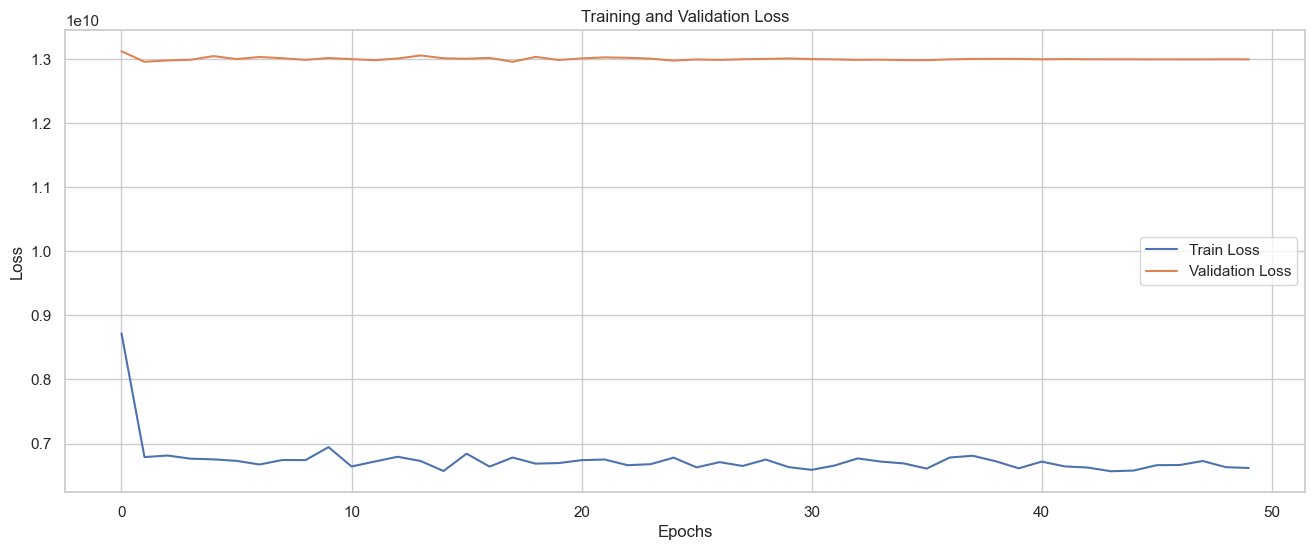

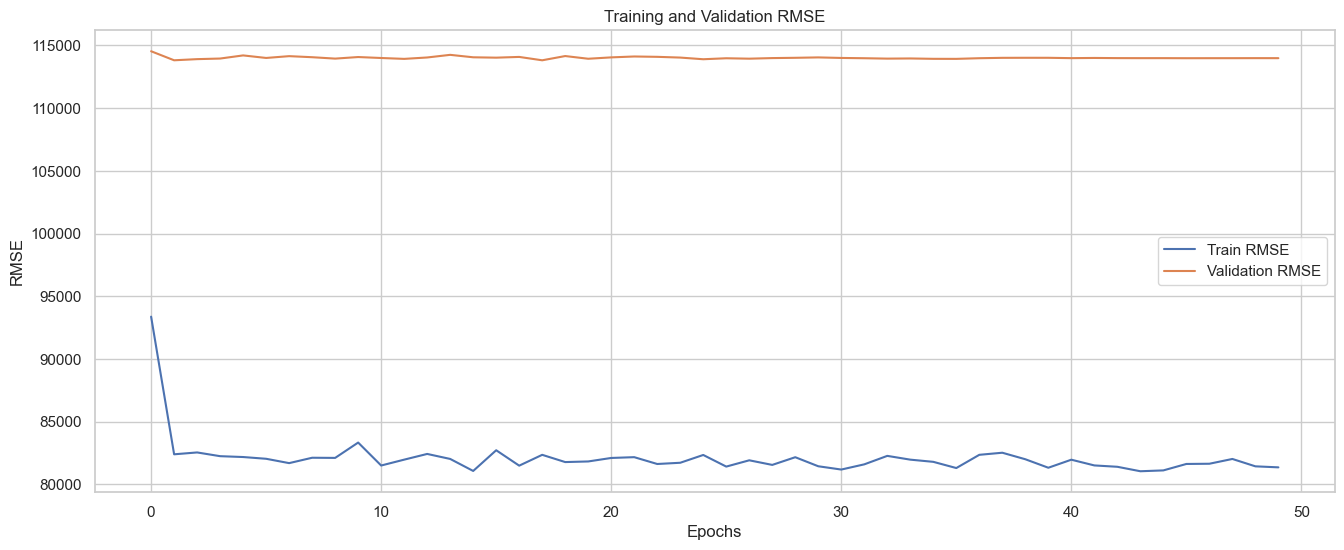

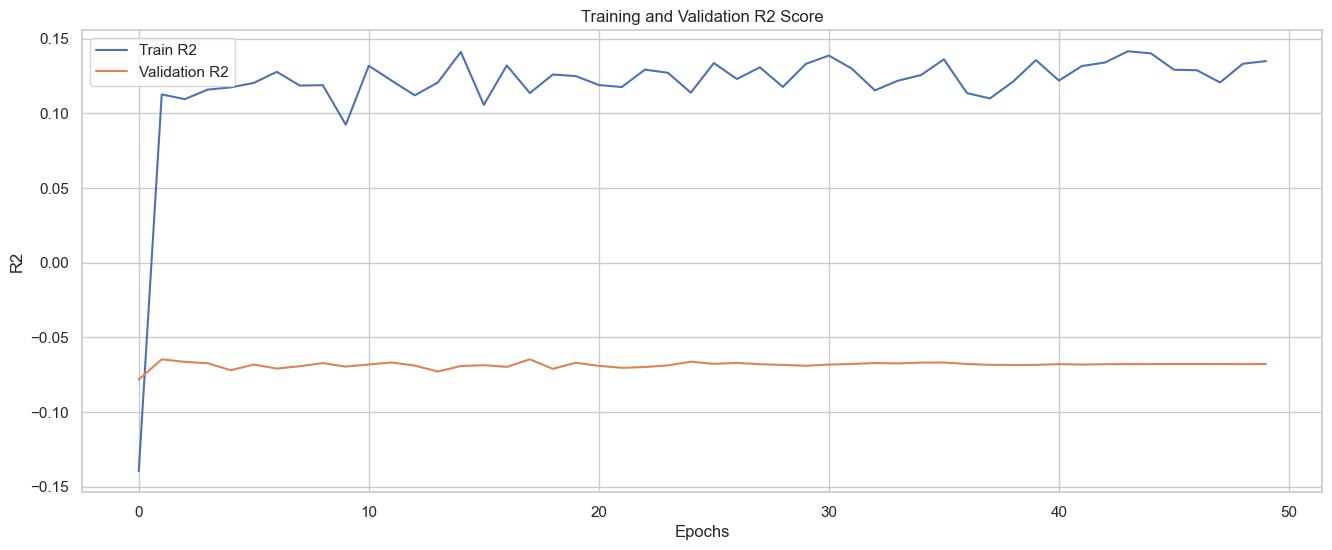

In [46]:
plot_grafs(metrics)

### Качество конечно ужасное, но это все данные)